In [1]:
%load_ext autoreload
%autoreload 2

# @title Imports and Notebook Utilities
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

from IPython.display import Image, HTML, Markdown, clear_output
from tqdm import tqdm_notebook, tnrange

import matplotlib.pyplot as plt


os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None, center_crop=False):
    if url.startswith(('http:', 'https:')):
        # wikimedia requires a user agent
        headers = {
            "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
        }
        r = requests.get(url, headers=headers)
        f = io.BytesIO(r.content)
    else:
        f = url
    img = PIL.Image.open(f)
    
    if center_crop:
        width, height = img.size   # Get dimensions
        
        new_width = min(width, height)
        new_height = min(width, height)

        left = (width - new_width)/2
        top = (height - new_height)/2
        right = (width + new_width)/2
        bottom = (height + new_height)/2

        # Crop the center of the image
        img = img.crop((left, top, right, bottom))
    
    
    if max_size is not None:
        img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
    if mode is not None:
        img = img.convert(mode)
    img = np.float32(img) / 255.0
    return img


def np2pil(a):
    if a.dtype in [np.float32, np.float64]:
        a = np.uint8(np.clip(a, 0, 1) * 255)
    return PIL.Image.fromarray(a)


def imwrite(f, a, fmt=None):
    a = np.asarray(a)
    if isinstance(f, str):
        fmt = f.rsplit('.', 1)[-1].lower()
        if fmt == 'jpg':
            fmt = 'jpeg'
        f = open(f, 'wb')
    np2pil(a).save(f, fmt, quality=95)


def imencode(a, fmt='jpeg'):
    a = np.asarray(a)
    if len(a.shape) == 3 and a.shape[-1] == 4:
        fmt = 'png'
    f = io.BytesIO()
    imwrite(f, a, fmt)
    return f.getvalue()


def im2url(a, fmt='jpeg'):
    encoded = imencode(a, fmt)
    base64_byte_string = base64.b64encode(encoded).decode('ascii')
    return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string


def imshow(a, fmt='jpeg', id=None):
    return display(Image(data=imencode(a, fmt)), display_id=id)


def grab_plot(close=True):
    """Return the current Matplotlib figure as an image"""
    fig = pl.gcf()
    fig.canvas.draw()
    img = np.array(fig.canvas.renderer._renderer)
    a = np.float32(img[..., 3:] / 255.0)
    img = np.uint8(255 * (1.0 - a) + img[..., :3] * a)  # alpha
    if close:
        pl.close()
    return img


def tile2d(a, w=None):
    a = np.asarray(a)
    if w is None:
        w = int(np.ceil(np.sqrt(len(a))))
    th, tw = a.shape[1:3]
    pad = (w - len(a)) % w
    a = np.pad(a, [(0, pad)] + [(0, 0)] * (a.ndim - 1), 'constant')
    h = len(a) // w
    a = a.reshape([h, w] + list(a.shape[1:]))
    a = np.rollaxis(a, 2, 1).reshape([th * h, tw * w] + list(a.shape[4:]))
    return a


def zoom(img, scale=4):
    img = np.repeat(img, scale, 0)
    img = np.repeat(img, scale, 1)
    return img


class VideoWriter:
    def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
        self.writer = None
        self.params = dict(filename=filename, fps=fps, **kw)

    def add(self, img):
        img = np.asarray(img)
        if self.writer is None:
            h, w = img.shape[:2]
            self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
        if img.dtype in [np.float32, np.float64]:
            img = np.uint8(img.clip(0, 1) * 255)
        if len(img.shape) == 2:
            img = np.repeat(img[..., None], 3, -1)
        self.writer.write_frame(img)

    def close(self):
        if self.writer:
            self.writer.close()

    def __enter__(self):
        return self

    def __exit__(self, *kw):
        self.close()
        if self.params['filename'] == '_autoplay.mp4':
            self.show()

    def show(self, **kw):
        self.close()
        fn = self.params['filename']
        display(mvp.ipython_display(fn, **kw))


class LoopWriter(VideoWriter):
    def __init__(self, *a, cross_len=1.0, **kw):
        super().__init__(*a, **kw)
        self._intro = []
        self._outro = []
        self.cross_len = int(cross_len * self.params['fps'])

    def add(self, img):
        if len(self._intro) < self.cross_len:
            self._intro.append(img)
            return
        self._outro.append(img)
        if len(self._outro) > self.cross_len:
            super().add(self._outro.pop(0))

    def close(self):
        for t in np.linspace(0, 1, len(self._intro)):
            img = self._intro.pop(0) * t + self._outro.pop(0) * (1.0 - t)
            super().add(img)
        super().close()


In [2]:
import torch
import torchvision.models as models
import torch.nn.functional as F

torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [3]:
from loss.appearance_loss import AppearanceLoss

class Args:
    appearance_loss_type = "Gram"
    DEVICE = torch.device("cuda:0")
    img_size = 256
    
    loss_scales = np.arange(5)
    # loss_scales = [0]
    
    
args = Args()
loss_fn = AppearanceLoss(args)

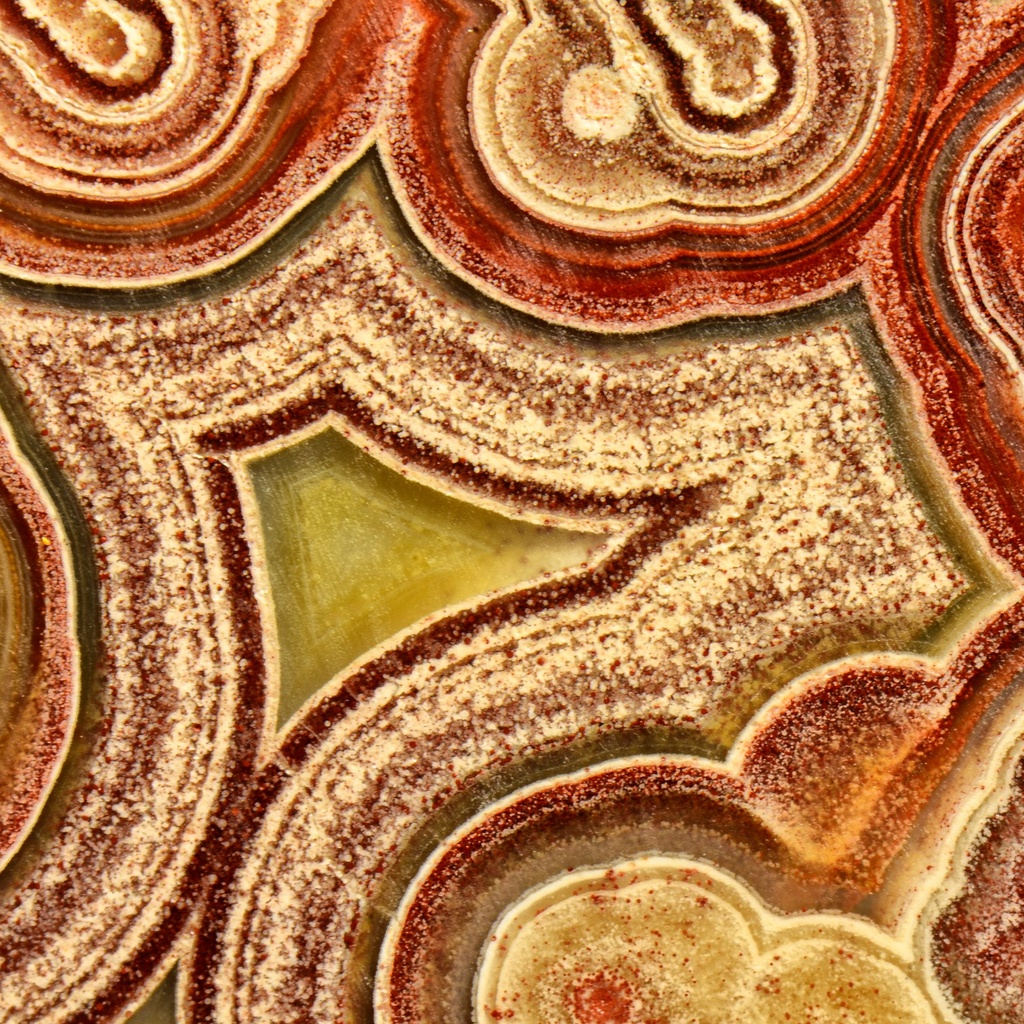

In [4]:
# @title Target image {vertical-output: true}
url = 'https://www.robots.ox.ac.uk/~vgg/data/dtd/thumbs/bubbly/bubbly_0101.jpg'
url = 'https://image6.photobiz.com/2332/9_20170620185424_8990918_xlarge.jpg'
# url = 'https://www.robots.ox.ac.uk/~vgg/data/dtd/thumbs/dotted/dotted_0201.jpg'

# style_img = imread(url, max_size=128)
style_img = imread(url, center_crop=True, max_size=1024)


target_image = torch.from_numpy(style_img).to(args.DEVICE) * 2.0 - 1.0
target_image = target_image.permute(2, 0, 1)[None, ...]

imshow(style_img)


In [5]:
# @title setup training


x = torch.zeros(1, 3, 512, 512, device=args.DEVICE, requires_grad=True)

opt = torch.optim.LBFGS([x])
# opt = torch.optim.Adam([x],lr=1e-2)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [1000, 2000], 0.3)
loss_log = []

input_dict = {}


def closure():
    opt.zero_grad()
    objective, _, _ = loss_fn(input_dict)
    objective.backward()
    return objective


                step_n: 2991
                loss: 2.17360258102417
                lr: 0.09

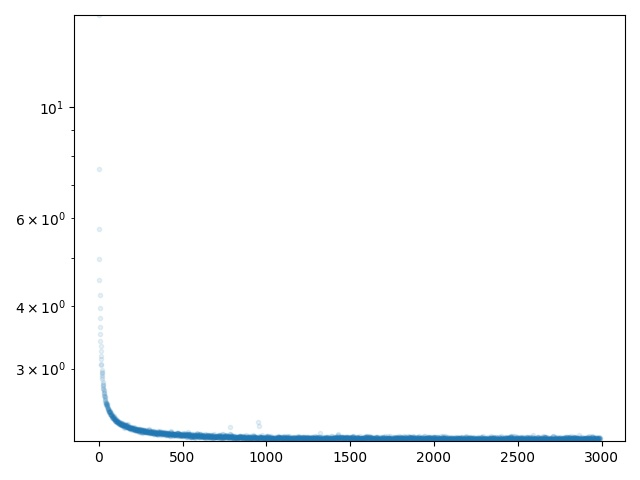

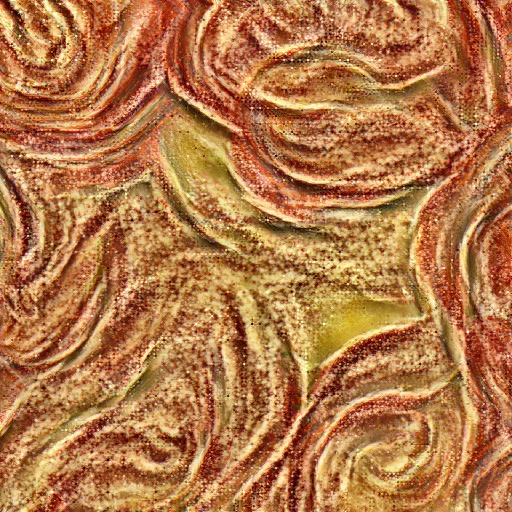

In [6]:
# @title training loop {vertical-output: true}

gradient_checkpoints = False  # Set in case of OOM problems


for i in range(3000):

    input_dict['target_images'] = target_image
    input_dict['generated_images'] = x
        
    texture_loss, _, _ = loss_fn(input_dict)
    
    loss = texture_loss
    
    opt.step(closure)
    lr_sched.step()
    
    with torch.no_grad():
        # x = torch.clamp(x, -1.0, 1.0) 

        loss_log.append(loss.item())

        if i % 10 == 0:
            clear_output(True)
            display(Markdown(f'''
                step_n: {len(loss_log)}
                loss: {loss.item()}
                lr: {lr_sched.get_last_lr()[0]}'''), display_id='stats')
            pl.plot(loss_log, '.', alpha=0.1)
            pl.yscale('log')
            pl.ylim(np.min(loss_log), loss_log[0])
            pl.tight_layout()
            imshow(grab_plot(), id='log')
            imgs = (x / 2.0 + 0.5).permute([0, 2, 3, 1]).cpu()
            imshow(np.hstack(imgs), id='batch')
